## First look at only the first 10K lines of one of the monthly pageview files
Just for developmental purposes, decompress the first 10K lines of one of the files to work with to develop the process. 

```sh
bzcat pageviews-202309-user.bz2 | head -n 10000 > test_data.txt
```

Data format:
 - https://dumps.wikimedia.org/other/pageview_complete/readme.html

 ```
wiki code (subproject.project)
article title
page id
daily total
hourly counts
 ```

In [1]:
datafile = "/Users/einar/git/hafsteinn/together_rag/data/wikipedia_meta/test/test_data.txt"
!head -n 2 {datafile}

aa.wikibooks - null desktop 2 J1V1
aa.wikibooks - null mobile-web 1 W1


In [2]:
import pandas as pd

# basically if the line only has 5 columns, we skip it. 
# also we are only interested in no wiki in this test, 
# the start of all lines is e.g. aa.wikibooks 

keep_data = []
with open(datafile, "r") as f:
    for line in f:
        l = line.strip().split()
        if len(l) == 5:
            continue
        elif len(l) == 6:
            l = [w.strip() for w in l]
            keep_data.append(l)
        else:
            raise ValueError(f"Line has {len(l)} columns: {l}")

len(keep_data)

10000

In [3]:
"""
FROM: https://dumps.wikimedia.org/other/pageview_complete/readme.html

Wikistats: Pageview complete dumps
Maintained by the Wikimedia Analytics team Link to the dumps
Pageview complete is our best effort to provide a comprehensive timeseries of per-article pageview data for Wikimedia projects. Data spans from December 2007 to the present with a uniform format and compression.

Features of the dataset

Unified, human-readable project names (e.g. es.wikisource instead of es.s)
Page IDs (from 2015 onwards) that allow this dataset to be joined with Wikidata and MediaWiki History
Corrected one-hour skewing problem
Where available, agent type and access method dimensions exposed.
From 2020 on, it includes numbers on agents detected through our bot detection filters
KNOWN ISSUE: rows without Page IDs have only 5 columns, while rows with Page IDs have 6. We are applying a fix which will take some time.
Details on data segments

Sets of daily files are derived from the best data available at the time:

From 2007 to 2011: from pagecounts-raw (to be loaded during the second half of October 2020)
From 2011 to 2015: from pagecounts-ez
From 2015 to the present: from the latest pageview definition
Data format

Compression of dataset is similar to that of pagecounts-ez: bzip files with hourly data embedded on each row, following this format:


wiki code (subproject.project)
article title
page id
daily total
hourly counts
Hourly counts can be deciphered as follows:

Hour:
from 0 to 23, written as 0 = A, 1 = B ... 22 = W, 23 = X
"""

df = pd.DataFrame(keep_data, columns=['wiki_code', 'article_title', 'page_id', 'access_method', 'daily_total', 'hourly_counts'])

df.tail(10)

,wiki_code,article_title,page_id,access_method,daily_total,hourly_counts
9990,ab.wikipedia,Акатегориа:1285_шықәсазы_иԥсыз,13990,mobile-web,2,H1J1
9991,ab.wikipedia,Акатегориа:1285_шықәсазы_иԥсыз,13990,desktop,1,\1
9992,ab.wikipedia,Акатегориа:1286_шықәса,16080,desktop,1,[1
9993,ab.wikipedia,Акатегориа:1286_шықәсазы_иԥсыз,13991,mobile-web,1,]1
9994,ab.wikipedia,Акатегориа:1286_шықәсазы_иԥсыз,13991,desktop,1,X1
9995,ab.wikipedia,Акатегориа:1287_шықәса,16081,mobile-web,1,U1
9996,ab.wikipedia,Акатегориа:1287_шықәса,16081,desktop,3,M1V1\1
9997,ab.wikipedia,Акатегориа:1287_шықәсазы_ииз,12245,mobile-web,1,W1
9998,ab.wikipedia,Акатегориа:1288_шықәса,16082,mobile-web,1,J1
9999,ab.wikipedia,Акатегориа:1288_шықәса,16082,desktop,1,\1


In [4]:
# find the page ids mentioned most often
df['article_title'].value_counts()

article_title
-                       23
Main_Page               10
Plants_vs._Zombies_2     6
Special:SpecialPages     6
Special:Book             6
                        ..
User:31.178.170.92       1
User:31.175.135.13       1
User:31.174.22.31        1
User:31.11.163.105       1
Special:Log/Vfew         1
Name: count, Length: 6531, dtype: int64

In [5]:
df[df.article_title == "Plants_vs._Zombies_2"]

,wiki_code,article_title,page_id,access_method,daily_total,hourly_counts
7864,ab.wikipedia,Plants_vs._Zombies_2,36126,desktop,1,V1
7865,ab.wikipedia,Plants_vs._Zombies_2,null,desktop,2,D2
7866,ab.wikipedia,Plants_vs._Zombies_2,35364,desktop,1,D1
7867,ab.wikipedia,Plants_vs._Zombies_2,36902,desktop,1,[1
7868,ab.wikipedia,Plants_vs._Zombies_2,35227,desktop,2,C2
7869,ab.wikipedia,Plants_vs._Zombies_2,36614,desktop,1,Y1


**is this time series data?**

Is that why it is so large?

In [6]:
df.wiki_code.value_counts()


wiki_code
ab.wikipedia     6805
aa.wikipedia     2317
aa.wikibooks      459
aa.wiktionary     419
Name: count, dtype: int64

In [7]:
import pandas as pd

df["daily_total"] = df["daily_total"].astype(int)

# Assuming your DataFrame is named 'df'
monthly_stats = df.groupby(['wiki_code', 'article_title']).agg({
    "daily_total": "sum",
    'page_id': lambda x: list(set([i for i in x if i != 'null']))  # This creates a list of unique page_ids, excluding 'null'
}).reset_index().rename(columns={"daily_total": "monthly_views"})

# Sort by total views in descending order
monthly_stats = monthly_stats.sort_values('monthly_views', ascending=False)

monthly_stats.head(10)

,wiki_code,article_title,monthly_views,page_id
6016,ab.wikipedia,Авикипедиа:Афорум,19445,[3626]
1024,aa.wikipedia,Special:UserLogin,13689,[]
558,aa.wikipedia,Main_Page,10954,[]
34,aa.wikibooks,Main_Page,2989,[]
2456,aa.wikipedia,Wikipedia:Community_Portal,2335,[]
2454,aa.wikipedia,Wikipedia:Administrators,1516,[]
6012,ab.wikipedia,Авикипедиа:Алфавиттә_арбага,1377,[9669]
2496,aa.wiktionary,Main_Page,1291,[]
5982,ab.wikipedia,Авикипедиа:Aкатегориақәа_алԥшаара,1170,"[9666, 28790]"
4540,ab.wikipedia,6,813,[4246]


In [8]:
monthly_stats.tail(5)

,wiki_code,article_title,monthly_views,page_id
870,aa.wikipedia,Special:Log/Cbrown1023,1,[]
869,aa.wikipedia,Special:Log/BotMultichill,1,[]
867,aa.wikipedia,Special:Log/Alecs.bot,1,[]
866,aa.wikipedia,Special:Log/Al_Riaz_Uddin_Ripon,1,[]
5068,ab.wikipedia,??????????_21,1,[6901]


Text(0, 0.5, 'Frequency')

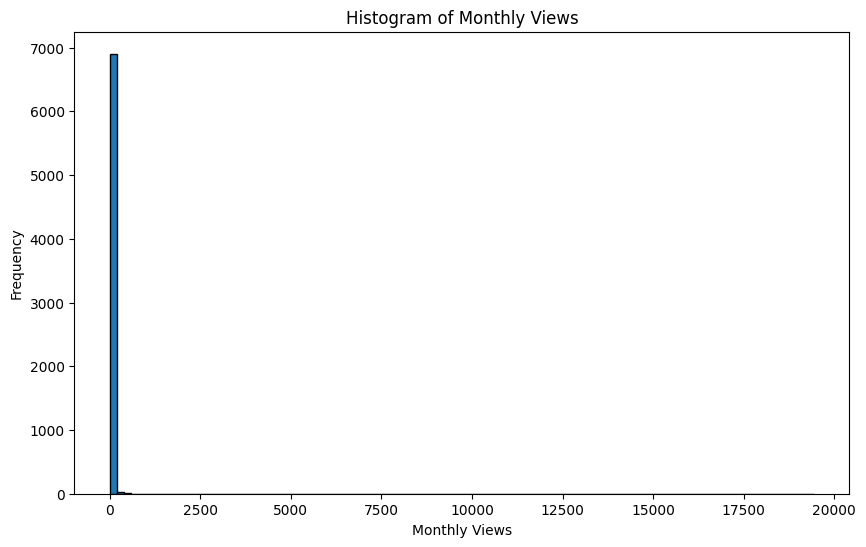

In [9]:
# histogram plot
import matplotlib.pyplot as plt

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(monthly_stats['monthly_views'], bins=100, edgecolor='black')
plt.title('Histogram of Monthly Views')
plt.xlabel('Monthly Views')
plt.ylabel('Frequency')



**the numbers at least seem very plausible**

In [12]:
# plt.figure(figsize=(10, 6))
# plt.hist(monthly_stats[
#     monthly_stats.monthly_views < 1000
# ]["monthly_views"], bins=100, edgecolor='black')
# plt.title('Histogram of Monthly Views')
# plt.xlabel('Monthly Views')
# plt.ylabel('Frequency')

In [10]:
df[df.article_title == "Main_Page"]

,wiki_code,article_title,page_id,access_method,daily_total,hourly_counts
40,aa.wikibooks,Main_Page,null,desktop,2774,A358B56C276D67E45F52G102H108I175J105K85L148M44...
41,aa.wikibooks,Main_Page,null,mobile-web,215,A18B11C8D11E8F8G5H4I9J8K7L9M9O8P7Q6R9S6T5U12V1...
630,aa.wikipedia,Main_Page,null,desktop,9198,A937B250C468D282E241F294G279H298I800J351K262L2...
631,aa.wikipedia,Main_Page,null,mobile-web,1756,A25B32C27D60E140F137G49H44I35J38K35L47M45N39O2...
2800,aa.wiktionary,Main_Page,null,desktop,1068,A144B17C72D22E34F23G23H57I46J34K22L68M32N13O24...
2801,aa.wiktionary,Main_Page,null,mobile-web,223,A6B5C13D9E10F8G7H11I9J8K6L10M4N2O5P16Q4R2S3T7U...
7757,ab.wikipedia,Main_Page,1,mobile-web,4,^4
7758,ab.wikipedia,Main_Page,2022,mobile-web,3,I1U1^1
7759,ab.wikipedia,Main_Page,2022,desktop,6,A1O1P1W1X1[1
7760,ab.wikipedia,Main_Page,1,desktop,3,K1M1S1


# Now test how this would look for one single .bz2 file

In [11]:
wiki_codes_to_keep = [
    "is.wikipedia",
    "no.wikipedia",
    "nn.wikipedia",
    "en.wikipedia",
    "de.wikipedia",
    "fo.wikipedia",
    "nl.wikipedia",
    "se.wikipedia",
    "dk.wikipedia",
    "lu.wikipedia",
]

datafile = "/Users/einar/git/hafsteinn/together_rag/data/wikipedia_meta/pageviews-202309-user.bz2"



In [12]:
import bz2
from collections import defaultdict
import csv
import io

def process_pageviews(bz2_file_path, wiki_codes_to_keep):
    # Initialize a defaultdict to store the monthly views
    monthly_views = defaultdict(lambda: {"views": 0, "page_ids": set()})

    with bz2.open(bz2_file_path, "rt") as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) < 6:
                continue  # Skip invalid lines

            wiki_code = parts[0].strip()
            if wiki_code not in wiki_codes_to_keep:
                continue  # Skip unwanted wiki codes

            article_title = parts[1].strip()
            page_id = parts[2].strip()
            daily_total = int(parts[-2].strip())

            key = (wiki_code, article_title)
            monthly_views[key]["views"] += daily_total
            
            monthly_views[key]["page_ids"].add(page_id)

    return monthly_views


# def process_monthly(monthly_views):
#     # Convert the defaultdict to a list of dictionaries
#     result = [
#         {
#             "wiki_code": key[0],
#             "article_title": key[1],
#             "monthly_views": value["views"],
#             "page_ids": list(value["page_ids"])
#         }
#         return result

# Example usage
bz2_file_path = "/Users/einar/git/hafsteinn/together_rag/data/wikipedia_meta/pageviews-202309-user.bz2"

monthly_stats = process_pageviews(bz2_file_path, wiki_codes_to_keep)

len(monthly_stats)

31386597

**Took around 5m to process one of the files.** 

Not really worth it to parallelize this, just set it to run while doing other stuff. 


In [13]:
def print_sample_dict(d, n=10):
    i = 0
    for k, v in d.items():
        print(k, v)
        i += 1
        if i >= n:
            break

print_sample_dict(monthly_stats)


('de.wikipedia', '!') {'views': 70, 'page_ids': {'152536', '165242'}}
('de.wikipedia', '!!') {'views': 10, 'page_ids': {'5014872', '7745134'}}
('de.wikipedia', '!!!') {'views': 90, 'page_ids': {'null', '554882'}}
('de.wikipedia', '!=') {'views': 11, 'page_ids': {'2744755', '244661'}}
('de.wikipedia', '!?') {'views': 5, 'page_ids': {'1148433'}}
('de.wikipedia', '!Amerika!') {'views': 10, 'page_ids': {'7481397', '4617370'}}
('de.wikipedia', '!Auchab') {'views': 3, 'page_ids': {'10998787'}}
('de.wikipedia', '!DelaDap') {'views': 2, 'page_ids': {'1675356'}}
('de.wikipedia', '!DonnerwetteR!') {'views': 62, 'page_ids': {'7481402', '2875892'}}
('de.wikipedia', '!Donnerwetter!') {'views': 11, 'page_ids': {'2875892'}}


In [14]:
# to df
import pandas as pd

def monthly_stats_to_df(monthly_stats):
    data = []
    for (wiki_code, article_title), stats in monthly_stats.items():
        data.append({
            'wiki_code': wiki_code,
            'article_title': article_title,
            'views': stats['views'],
            'page_ids': list(stats['page_ids'])
        })
    
    df = pd.DataFrame(data)
    # df = df.set_index(['wiki_code', 'article_title'])
    return df

df = monthly_stats_to_df(monthly_stats)
df.head()



,wiki_code,article_title,views,page_ids
0,de.wikipedia,!,70,"[152536, 165242]"
1,de.wikipedia,!!,10,"[5014872, 7745134]"
2,de.wikipedia,!!!,90,"[null, 554882]"
3,de.wikipedia,!=,11,"[2744755, 244661]"
4,de.wikipedia,!?,5,[1148433]


In [15]:
df.to_parquet("202309_monthly_views.parsed.parquet")

In [18]:
df[df.article_title.str.contains("Dalur_\(gj", case=False)].sort_values("views", ascending=False)

,wiki_code,article_title,views,page_ids
12156,is.wikipedia,Dalur_(gjaldmiðill),13,[30714]


In [19]:
df

,wiki_code,article_title,views,page_ids
0,is.wikipedia,$1,45,[30714]
1,is.wikipedia,%,2,[53329]
2,is.wikipedia,%s,1,[4]
3,is.wikipedia,(What's_The_Story)_Morning_Glory?,9,"[null, 33849]"
4,is.wikipedia,(_),7,[57709]
...,...,...,...,...
823709,no.wikipedia,🌹,1,[276067]
823710,no.wikipedia,🍆,1,[154626]
823711,no.wikipedia,😂,28,[1882548]
823712,no.wikipedia,🧄,1,[164590]


In [ ]:
# are the duplicate page ids
# inspect the duplicates
df[df.page_ids.duplicated()]

In [ ]:
df.page_ids.value_counts()

In [ ]:
# df.to_parquet()